In [1]:
import numpy as np
import pandas as pd

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials

## Load data

In [2]:
csv_path = "../data/raw/dayahead_2025_11.csv"

df, price_series, timestamps = load_price_data(
    csv_path,
    resolution="15min",
)

print(len(price_series), "time steps in full month (15 min resolution)")
print("From", timestamps[0], "to", timestamps[-1])

2880 time steps in full month (15 min resolution)
From 2025-11-01 00:00:00+01:00 to 2025-11-30 23:45:00+01:00


In [3]:
df = df.loc["2025-11-01":"2025-11-07"] # 672 steps (1 week)
price_week = df["Day Ahead Auktion"].values.astype(np.float32)
timestamps_week = df.index

print(len(price_week), "time steps in first week (should be 672)")
print("Week from", timestamps_week[0], "to", timestamps_week[-1])

672 time steps in first week (should be 672)
Week from 2025-11-01 00:00:00+01:00 to 2025-11-07 23:45:00+01:00


## Create BatteryEnv with 15-minute time step (discrete actions, 21 levels)

In [4]:
env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,              # 15 min
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,  # or False for continuous
    random_seed=42,
)

obs, info = env.reset()
obs

array([ 0.5717196 ,  1.        ,  0.        ,  1.        , -0.8674564 ,
        0.4975133 ,  0.30271953,  0.        ,  0.        ], dtype=float32)

## Run a 1-week random rollout (discrete actions)

Episode ended at step 671


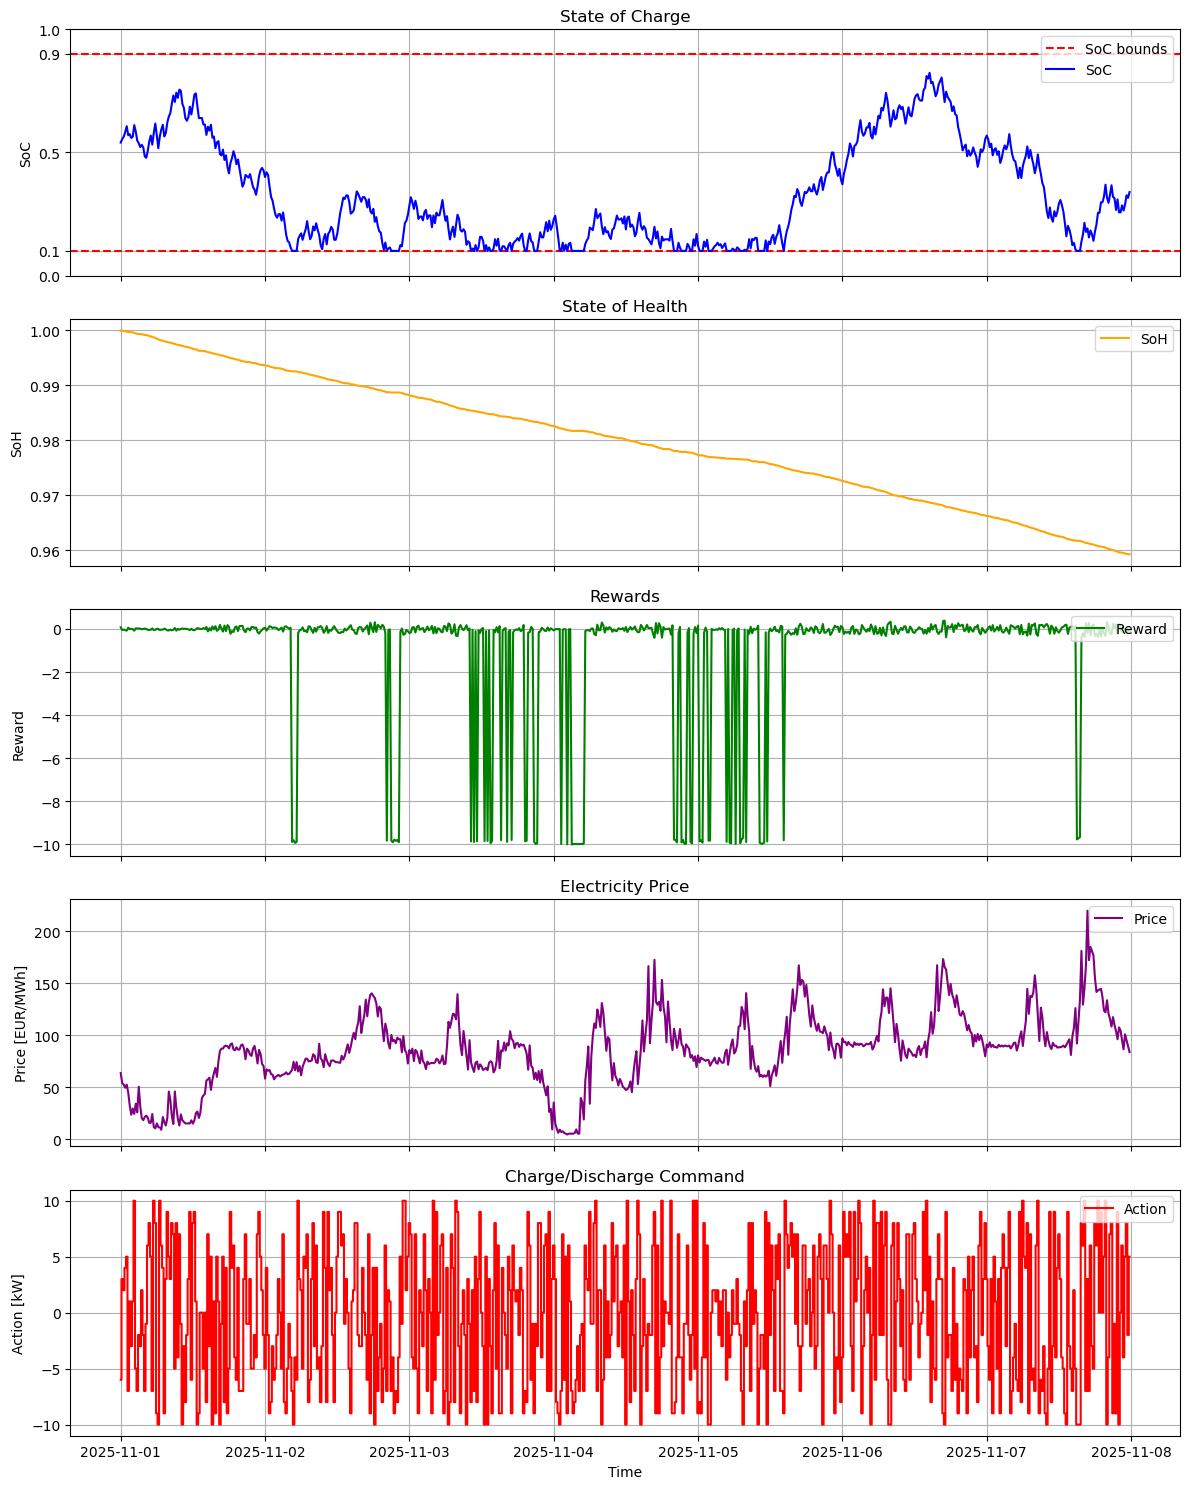

In [5]:
soc_list = []
soh_list = []
reward_list = []
price_true_list = []
action_kw_list = []

n_steps = len(price_week)  # max one week (672 Steps)

for t in range(n_steps):
    # sample random action index
    action_idx = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action_idx)
    
    soc_list.append(obs[0])
    soh_list.append(obs[1])
    reward_list.append(reward)
    price_true_list.append(info["price_true"])
    action_kw_list.append(env.discrete_action_values[action_idx])
    
    if terminated or truncated:
        print(f"Episode ended at step {t}")
        break

plot_bess_rollout(
    soc_list=soc_list,
    soh_list=soh_list,
    reward_list=reward_list,
    price_list=price_true_list,
    action_list=action_kw_list,
    timestamps=timestamps_week[:len(soc_list)],   # real time axis
)

## Create BatteryEnv with 15-minute time step (continuous actions)

In [6]:
env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,              # 15 min
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,
    random_seed=42,
)

obs, info = env.reset()
obs

array([ 0.5717196 ,  1.        ,  0.        ,  1.        , -0.8674564 ,
        0.4975133 ,  0.30271953,  0.        ,  0.        ], dtype=float32)

## Run a 1-week random rollout (continuous actions)

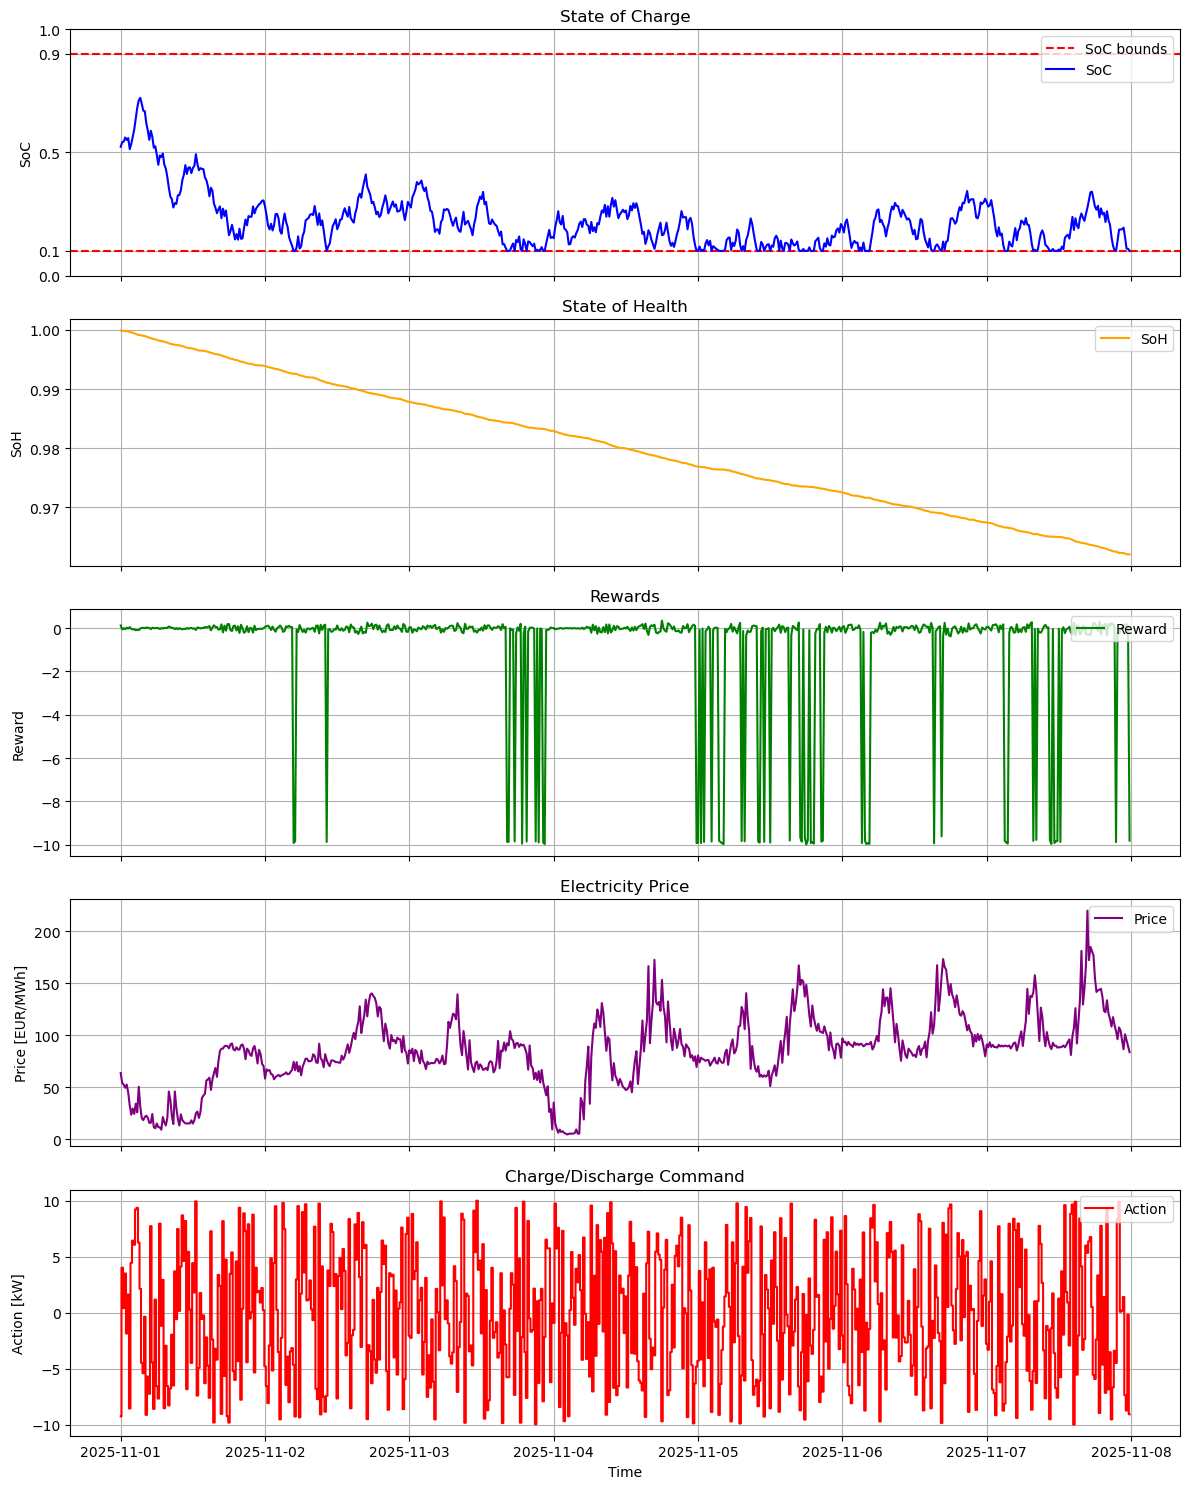

In [7]:
soc_list = []
soh_list = []
reward_list = []
price_true_list = []
action_list_cont = []

n_steps = len(price_week)

for t in range(n_steps):
    # sample random action index
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    soc_list.append(obs[0])
    soh_list.append(obs[1])
    reward_list.append(reward)
    price_true_list.append(info["price_true"])
    action_list_cont.append(float(action[0]))

    if terminated or truncated:
        break

plot_bess_rollout(
    soc_list=soc_list,
    soh_list=soh_list,
    reward_list=reward_list,
    price_list=price_true_list,
    action_list=action_list_cont,
    timestamps=timestamps_week[:len(soc_list)],
)